In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv("GlobalTemperatures.csv")

# Explore dataset
print("Shape of DataFrame:", df.shape)
print("Columns:", df.columns)
print(df.info())
print("Missing values:\n", df.isnull().sum())

Shape of DataFrame: (3192, 9)
Columns: Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature            

In [3]:
# Data preparation function
def wrangle(df):
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Drop columns with high uncertainty
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)
    
    # Function to convert Celsius to Fahrenheit
    def converttemp(x):
        return (x * 1.8) + 32
    
    # Apply temperature conversion and datetime transformations
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year
    
    # Drop unnecessary columns and filter data from 1850 onwards
    df = df.drop(["dt", "Month"], axis=1)
    df = df[df["Year"] >= 1850]
    
    # Set 'Year' as the index and drop rows with missing values
    df = df.set_index("Year").dropna()
    
    return df


In [4]:
# Apply data preparation function
global_temp = wrangle(df)

# Display first few rows of preprocessed data
print(global_temp.head())

      LandAverageTemperature  LandMaxTemperature  LandMinTemperature  \
Year                                                                   
1850                 33.3482             46.8356             26.2292   
1850                 37.5278             49.9460             27.8762   
1850                 40.9172             50.6246             28.5710   
1850                 44.9906             55.2812             33.8324   
1850                 50.0072             60.1790             38.8598   

      LandAndOceanAverageTemperature  
Year                                  
1850                         55.0994  
1850                         56.4584  
1850                         57.2774  
1850                         58.4006  
1850                         59.9126  


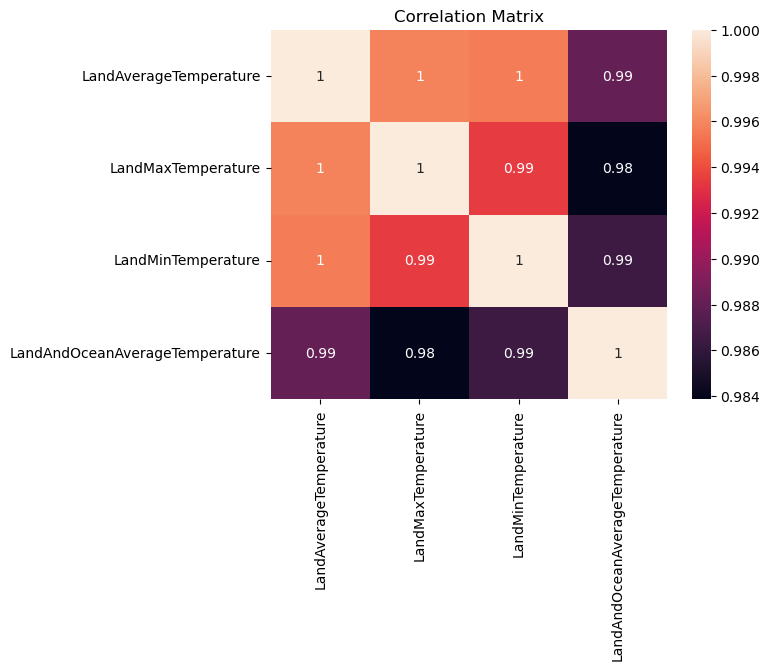

In [5]:
# Visualize correlation matrix
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [6]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

In [7]:
# Split data into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)

In [8]:
# Calculate baseline Mean Squared Error (MSE)
ypred = [ytrain.mean()] * len(ytrain)
baseline_mse = mean_squared_error(ytrain, ypred)
print("Baseline Mean Squared Error (MSE):", round(baseline_mse, 5))

Baseline Mean Squared Error (MSE): 5.29374


In [9]:
# Build and train the Random Forest model
forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(xtrain, ytrain)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [10]:
# Predict on validation set and evaluate the model
ypred = forest.predict(xval)
mae = mean_absolute_error(yval, ypred)
accuracy = 100 - mae  # Assuming accuracy is defined as 100 - MAE

In [11]:
# Print model evaluation metrics
print("Random Forest Model Evaluation:")
print("Mean Absolute Error (MAE):", round(mae, 5))
print("Accuracy:", round(accuracy, 2), "%")

Random Forest Model Evaluation:
Mean Absolute Error (MAE): 0.2443
Accuracy: 99.76 %
